In [1]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch

import sys
# Add the upper directory to the path
sys.path.append("../models/")
from CustomCNNVessel import CustomResNet
sys.path.append("../data/")
from VessMapDatasetLoader import vess_map_dataloader

torch.cuda.empty_cache()
device = torch.device("cuda")

In [2]:
# Old Model
model_custom_net = CustomResNet(num_classes=2).to(device)
# Load the weights
model_custom_net.load_state_dict(torch.load(f"../models/vess_map_regularized_none_200.pth"))
model = model_custom_net.eval()

In [3]:
# Original Images
import os
from PIL import Image
import numpy as np

def load_images_from_directory(directory_name):
    # Get the list of image file names in sorted order
    image_files = sorted(os.listdir(directory_name))

    # Load and store the images in a list
    images = []
    for file_name in image_files:
        if file_name.endswith('.png'):
            img_path = os.path.join(directory_name, file_name)
            img = Image.open(img_path)
            img_array = np.array(img)
            images.append(img_array)

    return images

# Load images from both directories
original_images = load_images_from_directory('/home/fonta42/Desktop/interpretacao-redes-neurais/experiments/cropped_images')

# Convert the lists to arrays if needed
original_images = torch.tensor(np.array(original_images) / 255.0, dtype=torch.float).to('cuda')
original_images.shape

torch.Size([100, 64, 64])

In [4]:
# Original images
fulfillment_images = []
for i in range(100):
  fulfillment_images.append(np.load(f'/home/fonta42/Desktop/interpretacao-redes-neurais/experiments/fulfillment_images/image_{i}.npy'))

fulfillment_images = np.array(fulfillment_images)

fulfillment_images.shape

(100, 64, 64)

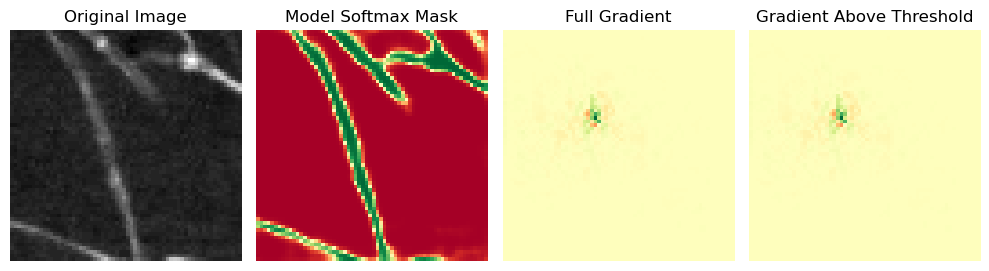

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `original_images`, `fulfillment_images`, and `model` are defined
selected_index = 0
original_image = original_images[selected_index].detach().cpu().numpy()
fulfillment_image = fulfillment_images[selected_index]

# Assuming `model` is a PyTorch model and images are PyTorch tensors
model_mask = model(original_images[selected_index].unsqueeze(0).unsqueeze(0))
softmax_probs = F.softmax(model_mask, dim=1)
class_one_probs = softmax_probs[0, 1, :, :].detach().cpu().numpy()

x = 24
y = 24
# Load the gradient for the selected index
loaded_gradient = torch.load(f'/home/fonta42/Desktop/interpretacao-redes-neurais/experiments/gradients/jacobian_gradient_{selected_index}.pt')[y,x]
max_val = torch.max(torch.abs(loaded_gradient)).cpu().item()
threshold = 0.01  # example threshold
threshold_val = (threshold / 100) * max_val
gradient_thresholded = (np.abs(loaded_gradient) > threshold_val) * loaded_gradient

# Create a figure with 4 subplots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 8))

# Plot original image
axes[ 0].imshow(original_image, cmap='gray')
axes[ 0].set_title('Original Image')
axes[ 0].axis('off')

# Plot model softmax mask
axes[ 1].imshow(class_one_probs, cmap='RdYlGn')
axes[ 1].set_title('Model Softmax Mask')
axes[ 1].axis('off')

# Plot full gradient
axes[ 2].imshow(loaded_gradient, cmap='RdYlGn', vmin=-max_val, vmax=max_val)
axes[ 2].set_title('Full Gradient')
axes[ 2].axis('off')

# Plot gradient filtered by threshold
axes[ 3].imshow(gradient_thresholded, cmap='RdYlGn', vmin=-max_val, vmax=max_val)
axes[ 3].set_title('Gradient Above Threshold')
axes[ 3].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [30]:
selected_index = 70
y = 40
x = 14

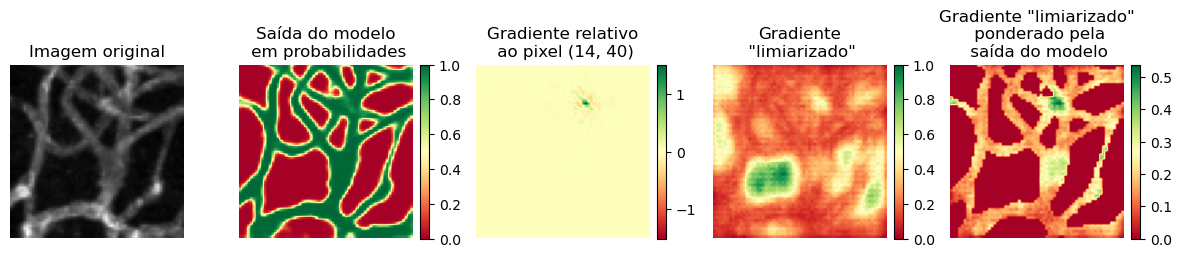

In [31]:
import matplotlib.pyplot as plt
import numpy as np



original_image = original_images[selected_index].detach().cpu().numpy()
fulfillment_image = fulfillment_images[selected_index] 

model_mask = model(original_images[selected_index].unsqueeze(0).unsqueeze(0))
softmax_probs = F.softmax(model_mask, dim=1)
class_one_probs = softmax_probs[0, 1, :, :].detach().cpu().numpy()

loaded_gradient = torch.load(f'/home/fonta42/Desktop/interpretacao-redes-neurais/experiments/gradients/jacobian_gradient_{selected_index}.pt')
max_val = torch.max(torch.abs(loaded_gradient)).cpu().item()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 2.5))

# Plot original image
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Imagem original')
axes[0].axis('off')

# Plot model softmax mask with colorbar
im1 = axes[1].imshow(class_one_probs, cmap='RdYlGn', vmin=0, vmax=1)
axes[1].set_title('Saída do modelo\n em probabilidades')
axes[1].axis('off')
fig.colorbar(im1, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

# Plot full gradient with colorbar
max_gradient = torch.max(loaded_gradient[x,y])
im2 = axes[2].imshow(loaded_gradient[x,y], cmap='RdYlGn', vmin=-max_gradient, vmax=max_gradient)
axes[2].set_title(f'Gradiente relativo\n ao pixel ({x}, {y})')
axes[2].axis('off')
fig.colorbar(im2, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)

# Plot fullfillment image with colorbar
im3 = axes[3].imshow(fulfillment_image, cmap='RdYlGn')
axes[3].set_title(f'Gradiente\n "limiarizado"')
axes[3].axis('off')
fig.colorbar(im3, ax=axes[3], orientation='vertical', fraction=0.046, pad=0.04)


# Plot fullfillment image with colorbar
im4 = axes[4].imshow((fulfillment_image* model_mask.argmax(dim=1).squeeze(0).detach().cpu().numpy()), cmap='RdYlGn')
axes[4].set_title(f'Gradiente "limiarizado"\n ponderado pela\n saída do modelo')
axes[4].axis('off')
fig.colorbar(im4, ax=axes[4], orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()
#plt.subplots_adjust(wspace=0, top=0.5) 
plt.savefig(f'/home/fonta42/Desktop/imagens-ic-relatorio-final/gradient_analysis_idx{selected_index}_pix({x}_{y}).pdf', format='pdf')
plt.show()